# Проект: Рекомендация тарифов для клиентов мобильной связи.

## Цели проекта:

Провести исследование с целью предложить пользователям новые тарифы «Смарт» или «Ультра» на основании их поведения.

Результаты исследования позволят специалистам выбрать более качественную модель, которая подберет новый тариф.

## Описание проекта:

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. «Мегалайн» хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Построим модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверить accuracy на тестовой выборке.

## 1. Откройте и изучите файл

In [272]:
# !pip install skimpy

In [273]:
# Все import соберем в начале проекта:
# import warnings
# warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline

import pandas as pd
import seaborn as sns
from skimpy import skim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier

from tqdm.auto import tqdm


RANDOM_FIX_NUMBER = 12345  # Введем глобальную переменную для значения random_state

pd.set_option('display.max_columns', None) # Не ограничиваем максимальное количество отображающихся столбцов

%config InlineBackend.figure_format = 'svg'

### 1.1. Загрузка локального и удаленного файла с данными:

Изучили файл с предоставленными данными **games.csv** и решили использовать символ **запятая** для разделения данных:

In [274]:
dataset_remote_path = 'https://code.s3.yandex.net/datasets/users_behavior.csv' # /datasets/users_behavior.csv
dataset_local_path = 'datasets/users_behavior.csv'  

try:
    data = pd.read_csv(dataset_local_path, sep=',')
    print('Local dataset is loaded successfully.')
except:
    data = pd.read_csv(dataset_remote_path, sep=',')
    print('Remote dataset is loaded successfully.')

Local dataset is loaded successfully.


### 1.2. Изучим датасет:

In [275]:
# Посмотрим, что за данные находятся в изучаемом файле:    
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


В нашем dataset всего 5 столбцов со следующей информацией:

* **сalls** — количество звонков,
* **minutes** — суммарная длительность звонков в минутах,
* **messages** — количество sms-сообщений,
* **mb_used** — израсходованный интернет-трафик в Мб,
* **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Видим, что названия столбцов соответствуют стилю **snake_case**. Отлично, поправлять названия столбцов не нужно.


In [276]:
# Воспользуемся модулем skim из пакета skimpy для получения информации о нашем датасете:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3214   │ │ float64     │ 4     │                                                          │
│ │ Number of columns │ 5      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %    ┃ mean     ┃ sd      ┃ p0   ┃ p25      ┃ p75      ┃ p100     ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ calls             │    0 │       0 │       63 │      33 │    0 │       40 │       82 │      240 │   ▄█▃▁   │  │
│ │ minutes           │    0 │       0 │      440 │     230 │    0 │      270 │      570 │     1600 │   ▄█▄▁   │  │
│ │ messages          │    0 │       0 │       38 │      36 │    0 │        9 │       57 │      220 │   █▄▂    │  │
│ │ mb_used           │    0 │       0 │    17000 │    7600 │    0 │    12000 │    21000 │    50000 │  ▂██▂▁   │  │
│ │ is_ultra          │    0 │       0 │     0.31 │    0.46 │    0 │        0 │        1 │        1 │  █    ▄  │  │
│ └───────────────────┴──────┴─────────┴──────────┴─────────┴──────┴──────────┴──────────┴──────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Видим:

1. Набор данных довольно большой. **3 214 строк х 5 столбцов!**
2. Четыре столбца типа float и 1 типа int. Далее проверим, какие конкретно признаки имеют эти типы.
3. Пропущенных значений нет.
4. Присмотревшись к гистограммам, принимем решение, что колонки *сalls* (количество звонков) и *minutes* (суммарная длительность звонков в минутах) следует проверить на **мультиколлинеарность**.
5. В признаке *is_ultra* всего два значения 0 и 1. По гистограмме видно, что распределены они неравномерно, нулевых значений много больше. **Нужно изучить** их дальше.

### 1.3. Поиск дубликатов:

In [277]:
data.duplicated().sum()

0

Отлично! **Дубликатов в нашей таблице нет.**

### 1.4. Проверим корректность типов данных:

Выведем основную информацию с помощью метода info()

In [278]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Видим, что **Типы данных корректные.**

### 1.5. Изучим наши данные на мультиколлинеарность признаков.

Посмотрим взаимную корреляцию признаков датасета:

In [279]:
data.corr()   # - коэффициент корреляции Пирсона

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Заметно очень высокое соответствие между *сalls* (количество звонков) и *minutes* (суммарная длительность звонков в минутах).
Коэффициент корреляции между этими признаками близок к 1 !

Посмотрим их еще и на heatmap:

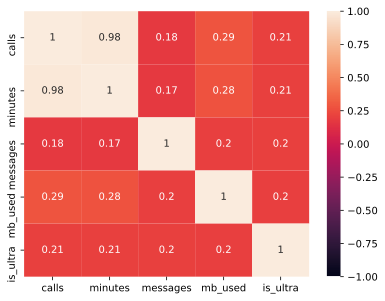

In [280]:
_ = sns.heatmap(data.corr(), vmax=1, vmin=-1, annot=True)

Между остальными признаками нет зависимости, коэффициенты корреляции между другими признаками в диапазоне 0.17 - 0.29. С ними и будем работать.

Оставим только независимые признаки. Удалять колонку *minutes* в исходном датасете не будем, просто в дальнейшей работе признак *minutes* использовать не будем!

### 1.6. Посмотрим внимательно на признак *is_ultra*:

In [281]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

В признаке *is_ultra* значения 0 и 1 распределены сильно неравномерно. Посмотрим пропорцию между ними:

In [282]:
is_ultra_0 = data[data['is_ultra'] == 0]['is_ultra'].count() # количество нулевых значений
is_ultra_1 = data[data['is_ultra'] == 1]['is_ultra'].count() # количество значений, равных единице 

In [283]:
print(f'Количество нулевых значений is_ultra: {is_ultra_0:.0f}.')
print(f'Количество значений is_ultra, равных единице: {is_ultra_1:.0f}.')
print(f'Отношение между количеством нулей и единиц: {is_ultra_0 / is_ultra_1:.2f} !')

Количество нулевых значений is_ultra: 2229.
Количество значений is_ultra, равных единице: 985.
Отношение между количеством нулей и единиц: 2.26 !


Столь большую разницу в их количествах нужно контролировать при последующем делении на валидационные и тестовые данные!

### 1.7. Промежуточный вывод:

1. Датасет готов к дальнейшей работе.
2. Признак *minutes* в дальнейшем не учитываем при анализе, так как он сильно коррелирует с признаком *calls*.
3. При разделении данных целевых признаков на валидационные и тестовые контролируем пропорцию между 0 и 1.

## 2. Разбейте данные на выборки

### 2.1 Разделим данные на признаки для обучения *features* и целевой признак *target*:

In [284]:
features = data.drop(['minutes', 'is_ultra'], axis=1) # решение об исключении *minutes* принято ранее
target = data['is_ultra'] 

Проверим их размеры:

In [285]:
features.shape, target.shape

((3214, 3), (3214,))

Отлично. Ничего не потеряли - все 3214 объекта присутствуют)

### 2.2 Разделим исходные данные на обучающую, валидационную и тестовую выборки в пропорции 3 : 1 : 1 (60% : 20% : 20%) :

**2.2.1. Выделим тестовую выборку в размере 20% из общего масиива данных:**

In [286]:
features_working, features_test, target_working, target_test = train_test_split(
    features, target, test_size=0.20, random_state=RANDOM_FIX_NUMBER)

**2.2.2. Из оставшейся части выделим валидационную выборку в размере 25%**

Это будет составлять 20% из общего масиива данных:

In [287]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_working, target_working, test_size=0.25, random_state=RANDOM_FIX_NUMBER)

**2.2.3. Посмотрим размеры получившихся выборок:**

In [288]:
# Признаки обучения:
features_train.shape, features_valid.shape, features_test.shape

((1928, 3), (643, 3), (643, 3))

In [289]:
# Целевые признаки:
target_train.shape, target_valid.shape, target_test.shape

((1928,), (643,), (643,))

In [290]:
#features_train, features_valid, target_train, target_valid = train_test_split(
#    features, target, test_size=0.20, random_state=RANDOM_FIX_NUMBER)

**2.2.4. Проверим, корректно ли разбиты датасеты:**

In [291]:
print(f'Обучающая выборка составляет: {features_train.shape[0]/data.shape[0]:.1%} % от исходного датасета.')
print(f'Валидационная выборка составляет: {features_valid.shape[0]/data.shape[0]:.1%} % от исходного датасета.')
print(f'Тестовая выборка составляет: {features_test.shape[0]/data.shape[0]:.1%} % от исходного датасета.')

Обучающая выборка составляет: 60.0% % от исходного датасета.
Валидационная выборка составляет: 20.0% % от исходного датасета.
Тестовая выборка составляет: 20.0% % от исходного датасета.


Все в порядке. Видим, что сохраняется пропорция 3:1:1 ( 60% : 20% : 20% ).

### 2.2 Проверим соотношение между нулями и единичками в валидационной и тестовой частях целевого признака:

**2.2.1. Обучающая часть целевого признака**

In [292]:
target_train_0 = target_train[target_train.values == 0].count()
target_train_1 = target_train[target_train.values == 1].count()

print(f'Количество нулевых значений is_ultra: {target_train_0:.0f}.')
print(f'Количество значений is_ultra, равных единице: {target_train_1:.0f}.')
print(f'Отношение между количеством нулей и единиц: {target_train_0 / target_train_1:.2f} !')

Количество нулевых значений is_ultra: 1339.
Количество значений is_ultra, равных единице: 589.
Отношение между количеством нулей и единиц: 2.27 !


**2.2.2. Валидационная часть целевого признака**

In [293]:
target_valid_0 = target_valid[target_valid.values == 0].count()
target_valid_1 = target_valid[target_valid.values == 1].count()

print(f'Количество нулевых значений is_ultra: {target_valid_0:.0f}.')
print(f'Количество значений is_ultra, равных единице: {target_valid_1:.0f}.')
print(f'Отношение между количеством нулей и единиц: {target_valid_0 / target_valid_1:.2f} !')

Количество нулевых значений is_ultra: 443.
Количество значений is_ultra, равных единице: 200.
Отношение между количеством нулей и единиц: 2.21 !


**2.2.3. Тестовая часть целевого признака**

In [294]:
target_test_0 = target_test[target_test.values == 0].count()
target_test_1 = target_test[target_test.values == 1].count()

print(f'Количество нулевых значений is_ultra: {target_test_0:.0f}.')
print(f'Количество значений is_ultra, равных единице: {target_test_1:.0f}.')
print(f'Отношение между количеством нулей и единиц: {target_test_0 / target_valid_1:.2f} !')

Количество нулевых значений is_ultra: 447.
Количество значений is_ultra, равных единице: 196.
Отношение между количеством нулей и единиц: 2.23 !


**2.2.4. Сравнение значений 0 и 1 целевого признака**

In [295]:
print(f'Отношение между количеством нулей и единиц целевого признака: {is_ultra_0 / is_ultra_1:.2f} !')
print(f'Отношение между количеством нулей и единиц в обучающей части целевого признака: {target_train_0 / target_train_1:.2f} !')
print(f'Отношение между количеством нулей и единиц в валидационной части целевого признака: {target_valid_0 / target_valid_1:.2f} !')
print(f'Отношение между количеством нулей и единиц в тестовой части целевого признака: {target_test_0 / target_test_1:.2f} !')

Отношение между количеством нулей и единиц целевого признака: 2.26 !
Отношение между количеством нулей и единиц в обучающей части целевого признака: 2.27 !
Отношение между количеством нулей и единиц в валидационной части целевого признака: 2.21 !
Отношение между количеством нулей и единиц в тестовой части целевого признака: 2.28 !


Максимальная разность с распределением в целевом признаке 2.26 - 2.21 = 0.05, что в относительных единицах составляет:

In [296]:
print(f'Отношение между количеством нулей и единиц целевого признака: {(2.26 - 2.21) / 2.26:.1%}.')

Отношение между количеством нулей и единиц целевого признака: 2.2%.


Хорошо. Считаем удовлетворительным некоторый разброс данных целевого признака в обучающей, валидационной и тестовой выборках.

### 2.3. Промежуточный вывод:

* подготовленны данные для обучения модели: features_train, target_train
* подготовленны данные для валидации модели: features_valid, target_valid
* подготовлены тестовые данные: features_test, target_test

## 3. Исследуйте модели

### 3.1 Классификация *деревом решений*

**3.1.1. Построим модель *дерево решений*.**

In [297]:
# создадим пустую модель и сохраним её в переменной
model = DecisionTreeClassifier(random_state=RANDOM_FIX_NUMBER) 

# обучим модель вызовом метода fit()
model.fit(features_train, target_train)   

DecisionTreeClassifier(random_state=12345)

Проведем расчет значения *accuracy* - отношения числа правильных ответов к размеру обучающей / валидационной выборок

In [298]:
# расчёт на обучающей выборке (для самопроверки)
train_predictions = model.predict(features_train)
train_accuracy = accuracy_score(target_train, train_predictions) 

# расчёт на валидационной выборке
valid_predictions = model.predict(features_valid)
valid_accuracy = accuracy_score(target_valid, valid_predictions) 

# print("Значение accuracy для обучающей выборки:", round(train_accuracy,2))
print("Значение accuracy для валидационной выборки:", round(valid_accuracy, 2))

Значение accuracy для валидационной выборки: 0.71


**3.1.2. Оценим различные значения глубины дерева на валидационной выборке и найдем из них лучшее**

In [299]:
%%time

best_model_tree = None
best_result_tree = 0
best_depth_tree = 1

depth_tree = []           # список с глубиной дерева 
accuracy_train_tree = []  # список значений accuracy на обучающей выборке
accuracy_valid_tree = []  # список значений accuracy на валидационной выборке

# Построим модели с глубиной дерева от 1 до 15
for depth in tqdm(range(1, 16)):
    model_tree = DecisionTreeClassifier(random_state=RANDOM_FIX_NUMBER, max_depth=depth)  
    model_tree.fit(features_train, target_train) 
    
    predictions_train = model_tree.predict(features_train) # расчет качества модели на обучающей выборке
    predictions_valid = model_tree.predict(features_valid) # расчет качества модели на валидационной выборке
    
    accuracy_train = accuracy_score(target_train, predictions_train)  
    accuracy_valid = accuracy_score(target_valid, predictions_valid)  
    
    depth_tree.append(depth) 
    accuracy_train_tree.append(accuracy_train)
    accuracy_valid_tree.append(accuracy_valid)
    
    if accuracy_valid > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = accuracy_valid
        best_depth_tree = depth

print('Наилучшая модель "дерево решений":', best_model_tree)
print('Значение accuracy лучшей модели "дерево решений":', round(best_result_tree, 3))
print('Глубина дерева лучшей модели "дерево решений":', best_depth_tree)

  0%|          | 0/15 [00:00<?, ?it/s]

Наилучшая модель "дерево решений": DecisionTreeClassifier(max_depth=10, random_state=12345)
Значение accuracy лучшей модели "дерево решений": 0.773
Глубина дерева лучшей модели "дерево решений": 10
CPU times: total: 109 ms
Wall time: 115 ms


**3.1.3. Построим график зависимости качества моделей "дерево решений" от глубины дерева на обучающей и валидационной выборках:**

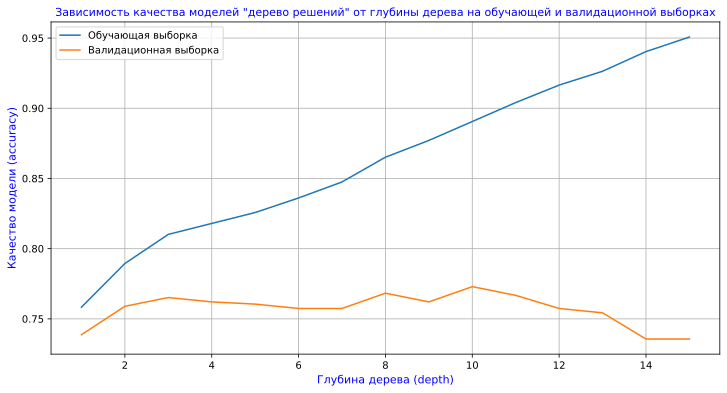

In [300]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(depth_tree, accuracy_train_tree)
plt.plot(depth_tree, accuracy_valid_tree)
plt.xlabel('Глубина дерева (depth)', color = 'Blue', fontsize=11)
plt.ylabel('Качество модели (accuracy)', color = 'Blue', fontsize=11)
plt.title('Зависимость качества моделей "дерево решений" от глубины дерева на обучающей и валидационной выборках', 
          color = 'Blue', fontsize=11)
plt.legend(['Обучающая выборка', 'Валидационная выборка'])
plt.show()


Видим, что действительно, наилучшее значение глубины дерева: 10.

**3.1.4. Построим дерево решений для лучшей модели (с глубиной дерева 10)**

Посмотрим, как модель распределяла значения израсходованного интернет-трафика, количества звонков, количества sms-сообщений для подбора оптимального тарифа.

In [301]:
# fig = plt.figure(figsize=(15,9))
# plot_tree(best_model_tree, 
#               feature_names=features_train.columns.values, 
#               class_names=['Smart','Ultra'],
#               filled=True,
#               fontsize = 8);

**3.1.5. Промежуточный вывод**

Наилучшая модель **дерево решений** на валидационной выборке имеет **accuracy = 0.773** при значении глубина дерева **depth = 10**

Создадим датафрейм (df_results), в котором, для каждой изучаемой модели, будут записаны значение accuracy, вермя расчета модели и лучшие параметры:

In [302]:
dict = {'model': ['дерево решений'],
        'programm':['DecisionTreeClassifier'],
        'accuracy':[0.773],
        'CPU times, ms': [125],
        'max_depth': [10],
        'n_estimators':['']
       }
df_results = pd.DataFrame(dict)
  
display(df_results)       

,model,programm,accuracy,"CPU times, ms",max_depth,n_estimators
0,дерево решений,DecisionTreeClassifier,0.773,125,10,


### 3.2 Классификация с помощью модели *случайный лес*.

In [303]:
%%time

best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0

for est in tqdm(range(1, 11)):
    for depth in range (1, 16):
        # обучаем модель с заданным количеством деревьев и глубиной дерева
        model_forest = RandomForestClassifier(random_state=RANDOM_FIX_NUMBER, n_estimators=est, max_depth=depth) 

        # обучаем модель на тренировочной выборке
        model_forest.fit(features_train, target_train) 

        # рассчитываем качество модели на валидационной выборке
        accuracy_valid_forest = model_forest.score(features_valid, target_valid) 

        if accuracy_valid_forest > best_result_forest:
            # сохраним наилучшую модель
            best_model_forest = model_forest           
            #  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_result_forest = accuracy_valid_forest 
            # сохраним наилучшее значение гиперпараметра n_estimators на валидационной выборке
            best_est_forest = est        
            # сохраним наилучшее значение гиперпараметра max_depth на валидационной выборке
            best_depth_forest = depth 

print('Наилучшая модель "случайный лес" на валидационной выборке:', best_model_forest)
print('Количество деревьев наилучшей модели "случайный лес" на валидационной выборке:', best_est_forest)
print('Глубина дерева наилучшей модели "случайный лес" на валидационной выборке:', best_depth_forest)
print("Значение accuracy наилучшей модели на валидационной выборке:", round(best_result_forest, 3))

  0%|          | 0/10 [00:00<?, ?it/s]

Наилучшая модель "случайный лес" на валидационной выборке: RandomForestClassifier(max_depth=10, n_estimators=5, random_state=12345)
Количество деревьев наилучшей модели "случайный лес" на валидационной выборке: 5
Глубина дерева наилучшей модели "случайный лес" на валидационной выборке: 10
Значение accuracy наилучшей модели на валидационной выборке: 0.806
CPU times: total: 2.03 s
Wall time: 2.04 s


**Промежуточные выводы:**

1. Наилучшая модель **случайный лес** на валидационной выборке имеет **accuracy = 0.806** при значениях количества деревьев **n_estimators = 5** и глубине дерева **max_depth = 10**.

2. Качество модели **случайный лес** на валидационной выборке **accuracy = 0.806** выше, чем у модели **дерево решений** **accuracy = 0.773**.

Добавим полученные результаты в датафрейм (df_results):

In [304]:
df_results.loc[len(df_results.index)] = ['случайный лес', 'RandomForestClassifier', 0.806, 2120, 10, 5] 
  
display(df_results) 

,model,programm,accuracy,"CPU times, ms",max_depth,n_estimators
0,дерево решений,DecisionTreeClassifier,0.773,125,10,
1,случайный лес,RandomForestClassifier,0.806,2120,10,5


### 3.3 Классификация с помощью модели *логистическая регрессия*.

In [305]:
%%time

model_log_regression = LogisticRegression(random_state=RANDOM_FIX_NUMBER, solver='lbfgs', max_iter=1000) 
model_log_regression.fit(features_train, target_train) 
best_result_log_regression = model_log_regression.score(features_valid, target_valid) 

print("Значение accuracy модели 'логистическая регрессия' на валидационной выборке:", round(best_result_log_regression, 3))

Значение accuracy модели 'логистическая регрессия' на валидационной выборке: 0.736
CPU times: total: 31.2 ms
Wall time: 29.5 ms


**Промежуточные выводы:**

1. Качество модели **логистическая регрессия** на валидационной выборке ниже, чем и у модели **дерево решений**, и у модели **случайный лес**.

2. Среди трех моделей лучшей явдяется модель **случайный лес** со значением **accuracy = 0.806** .

Добавим полученные результаты в датафрейм (df_results):

In [306]:
df_results.loc[len(df_results.index)] = ['логистическая регрессия', 'LogisticRegression', 0.736, 16, '', ''] 
df_results = df_results.drop_duplicates()  
display(df_results) 

,model,programm,accuracy,"CPU times, ms",max_depth,n_estimators
0,дерево решений,DecisionTreeClassifier,0.773,125,10,
1,случайный лес,RandomForestClassifier,0.806,2120,10,5
2,логистическая регрессия,LogisticRegression,0.736,16,,


## 4. Проверьте модель на тестовой выборке

In [316]:
predictions_test = model_forest.predict(features_test) # найдём предсказания на тестовой выборке
accuracy_test = accuracy_score(target_test, predictions_test) # вычислим долю правильных ответов

print("Значение accuracy в лучшей модели 'случайный лес', полученной на тестовой выборке:", round(accuracy_test, 3))

Значение accuracy в лучшей модели 'случайный лес', полученной на тестовой выборке: 0.792
CPU times: total: 0 ns
Wall time: 5 ms


Добавим полученные результаты в датафрейм (df_results):

In [308]:
df_results.loc[len(df_results.index)] = ['тестовая выборка', 'predict', 0.792, '', '', ''] 
df_results = df_results.drop_duplicates()  
df_results = df_results.sort_values('accuracy', ascending=False)

display(df_results) 

,model,programm,accuracy,"CPU times, ms",max_depth,n_estimators
1,случайный лес,RandomForestClassifier,0.806,2120,10,5
3,тестовая выборка,predict,0.792,,,
0,дерево решений,DecisionTreeClassifier,0.773,125,10,
2,логистическая регрессия,LogisticRegression,0.736,16,,


### **Промежуточные выводы:**

1. Значения *accuracy* для всех моделей  составляет 0.773, 0.806, 0.736. Таким образом, для лучшей модели оно превышают требуемое значение 0.75.
2. Значения *accuracy* на тестовой выборке (0.792) тоже превышает 0.75.
3. Требование по достижению *accuracy* значения 0.75 выполнено.

## (бонус) Проверьте модели на адекватность

Для проверки используем модель DummyClassifier.

In [317]:
model_dc = DummyClassifier(strategy='most_frequent', random_state=RANDOM_FIX_NUMBER)
model_dc.fit(features_train, target_train)
result_dc_valid = model_dc.score(features_valid, target_valid)
result_dc_test = model_dc.score(features_test, target_test)

print('Значение accuracy DummyClassifier по валидационной выборке:', round(result_dc_valid, 3))
print('Значение accuracy DummyClassifier по тестовой выборке:', round(result_dc_test, 3))

Значение accuracy DummyClassifier по валидационной выборке: 0.689
Значение accuracy DummyClassifier по тестовой выборке: 0.695
CPU times: total: 0 ns
Wall time: 2 ms


**Промежуточный вывод:**
    
Значения *accuracy* модели DummyClassifier (0.689 и 0.695) ниже, чем у выбранной нами модели (0.806), значит наша модель адекватна и эффективна.

Добавим полученные результаты в датафрейм (df_results):

In [318]:
df_results.loc[len(df_results.index)] = ['проверка на адекватность', 'DummyClassifier', 0.695, '', '', ''] 
df_results = df_results.drop_duplicates()  
df_results = df_results.sort_values('accuracy', ascending=False)

**Итоговые результаты всех моделей и их прорека приведена в датафрейме:**

In [319]:
display(df_results) 

,model,programm,accuracy,"CPU times, ms",max_depth,n_estimators
1,случайный лес,RandomForestClassifier,0.806,2120,10,5
3,тестовая выборка,predict,0.792,,,
0,дерево решений,DecisionTreeClassifier,0.773,125,10,
2,логистическая регрессия,LogisticRegression,0.736,16,,
4,проверка на адекватность,DummyClassifier,0.695,,,


## 6. Общий вывод

**По результатам исследования можно отметить следующие факты и сделать следующие выводы:**
  
1.Проведено исследование с целью разработки модели, позволяющей наиболее точно предложить пользователям мобильной связи тарифы «Смарт» или «Ультра».

2.Модель построена на основании поведения клиентов, уже перешедших на эти тарифы.

3.Были построены 3 модели:
- *'дерево решений'* ( Decision Tree Classifier ),
- *'случайный лес'* ( RandomForestClassifier ),
- *'логистическая регрессия'* ( Logistic Regression ).

4.По результатам сравнения была выбрана лучшая - *'случайный лес'* с гиперпараметрами *n_estimators* равным 5 и *max_depth* равным 10. Значение accuracy = 0.806.

5.Все модели соответствуют требованию по качеству, согласно которому значение *accuracy* должно быть не менее 0.75.

6.Лучшая модель проверена на тестовых объектах, не участвующих в обучении и валидации модели. Значение *accuracy = 0.788*.

7.Для проверки на адекватность выбранной нами модели *'случайный лес'* ( RandomForestClassifier ) использовали модель DummyClassifier, которая показала результат *accuracy* хуже, чем результат нашей лучшей модели.

8.Результаты исследования позволят специалистам выбрать наиболее качественную модель, которая подберет клиентам новый тариф.




[Вернутся к общему списку проектов курса “Data Science” Яндекс-практикума](../README.md)